In [ ]:
#__init.py__
__all__ = ['RNNEncoder', 'DilConvDecoder', 'GENTRL', 'MolecularDataset']

In [ ]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip "/content/drive/MyDrive/projects/ChemVAE/GENTRL-master.zip" -d "/content/drive/MyDrive/projects/ChemVAE"

In [ ]:
# Following resources were followed to get a sense of the problem statement and state of art of 
# Drug Discovery using Artificial Intelligence
# References: 
# [1] https://github.com/bhavikajain0001/chemical_vae
# [2] https://pubs.acs.org/doi/10.1021/acs.molpharmaceut.8b00839
# [3] https://towardsdatascience.com/unlocking-drug-discovery-through-machine-learning-part-1-8b2a64333e07
# [4] https://www.nature.com/articles/s41587-019-0224-x
# [5] https://towardsdatascience.com/word-level-english-to-marathi-neural-machine-translation-using-seq2seq-encoder-decoder-lstm-model-1a913f2dc4a7
# [6] https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjcpoHS9obuAhWXzDgGHUr8AVUQFjAFegQICBAC&url=http%3A%2F%2Fcs229.stanford.edu%2Fproj2020spr%2Freport%2FWoodward.pdf&usg=AOvVaw2CDXEbgwyzo6_1Xr88D9jQ

In [ ]:
#Done through pytorch and rdkit as it has made the implementation relatively simple
import torch

from torch.utils.data import Dataset

import pandas as pd
import numpy as np


class MolecularDataset(Dataset):
    def __init__(self, sources=[], props=['logIC50', 'BFL', 'pipeline'],
                 with_missings=False):
        self.num_sources = len(sources)

        self.source_smiles = []
        self.source_props = []
        self.source_missings = []
        self.source_probs = []

        self.with_missings = with_missings

        self.len = 0
        for source_descr in sources:
            cur_df = pd.read_csv(source_descr['path'])
            cur_smiles = list(cur_df[source_descr['smiles']].values)

            cur_props = torch.zeros(len(cur_smiles), len(props)).float()
            cur_missings = torch.zeros(len(cur_smiles), len(props)).long()

            for i, prop in enumerate(props):
                if prop in source_descr:
                    if isinstance(source_descr[prop], str):
                        cur_props[:, i] = torch.from_numpy(
                            cur_df[source_descr[prop]].values)
                    else:
                        cur_props[:, i] = torch.from_numpy(
                            cur_df[source_descr['smiles']].map(
                                source_descr[prop]).values)
                else:
                    cur_missings[:, i] = 1

            self.source_smiles.append(cur_smiles)
            self.source_props.append(cur_props)
            self.source_missings.append(cur_missings)
            self.source_probs.append(source_descr['prob'])

            self.len = max(self.len,
                           int(len(cur_smiles) / source_descr['prob']))

        self.source_probs = np.array(self.source_probs).astype(np.float)

        self.source_probs /= self.source_probs.sum()

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        trial = np.random.random()

        s = 0
        for i in range(self.num_sources):
            if (trial >= s) and (trial <= s + self.source_probs[i]):
                bin_len = len(self.source_smiles[i])
                sm = self.source_smiles[i][idx % bin_len]

                props = self.source_props[i][idx % bin_len]
                miss = self.source_missings[i][idx % bin_len]

                if self.with_missings:
                    return sm, torch.concat([props, miss])
                else:
                    return sm, props

            s += self.source_probs[i]

In [ ]:
#Decoder implementation
import torch
import torch.nn as nn
import torch.nn.functional as F


class DilConvDecoder(nn.Module):
    '''
        Class for autoregressive model that works in WaveNet manner.
        It make conditinioning on previosly sampled tokens by running
        stack of dilation convolution on them.
    '''
    def __init__(self, latent_input_size, token_weights=None,
                 split_len=50, num_dilated_layers=7, num_channels=128):
        r'''
        Arguments:
            -> latent_input_size: int, size of latent code used in VAE-like models
            -> token_weights: Tensor of shape [num_tokens], where i-th element
                              contains the weight of i-th token. If None, then all
                              tokens has the same weight.
            -> split_len: int, maximum length of token sequence
            -> num_dilated_layers: int, how much dilated layers is in stack
            -> num_channels: int, num channels in convolutional layers
        '''
        super(DilConvDecoder, self).__init__()
        self.vocab_size = get_vocab_size()
        self.latent_input_size = latent_input_size
        self.split_len = split_len
        self.num_dilated_layers = num_dilated_layers
        self.num_channels = num_channels
        self.token_weights = token_weights
        self.eos = 2

        cur_dil = 1
        self.dil_conv_layers = []
        for i in range(num_dilated_layers):
            self.dil_conv_layers.append(
                    DilConv1dWithGLU(num_channels, cur_dil))
            cur_dil *= 2

        self.latent_fc = nn.Linear(latent_input_size, num_channels)
        self.input_embeddings = nn.Embedding(self.vocab_size,
                                             num_channels)
        self.logits_1x1_layer = nn.Conv1d(num_channels,
                                          self.vocab_size,
                                          kernel_size=1)

        cur_parameters = []
        for layer in [self.input_embeddings, self.logits_1x1_layer,
                      self.latent_fc] + self.dil_conv_layers:
            cur_parameters += list(layer.parameters())

        self.parameters = nn.ParameterList(cur_parameters)

    def get_logits(self, input_tensor, z, sampling=False):
        '''
        Computing logits for each token input_tensor by given latent code - [WORKS ONLY IN TEACHER-FORCING MODE]
        
        Args:
            -> input_tensor: Tensor of shape [batch_size, max_seq_len]
            -> z: Tensor of shape [batch_size, lat_code_size]
        '''

        input_embedded = self.input_embeddings(input_tensor).transpose(1, 2)
        latent_embedded = self.latent_fc(z)

        x = input_embedded + latent_embedded.unsqueeze(-1)

        for dil_conv_layer in self.dil_conv_layers:
            x = dil_conv_layer(x, sampling=sampling)

        x = self.logits_1x1_layer(x).transpose(1, 2)

        return F.log_softmax(x, dim=-1)

    def get_log_prob(self, x, z):
        '''
        Getting logits of SMILES sequences
        Args:
            -> x: tensor of shape [batch_size, seq_size] with tokens
            -> z: tensor of shape [batch_size, lat_size] with latents
        Returns:
            -> logits: tensor of shape [batch_size, seq_size]
        '''
        seq_logits = torch.gather(self.get_logits(x, z)[:, :-1, :],
                                  2, x[:, 1:].long().unsqueeze(-1))

        return seq_logits[:, :, 0]

    def forward(self, x, z):
        '''
        Getting logits of SMILES sequences
        Args:
            -> x: tensor of shape [batch_size, seq_size] with tokens
            -> z: tensor of shape [batch_size, lat_size] with latents
        Returns:
            -> logits: tensor of shape [batch_size, seq_size]
            -> None: since dilconv decoder doesn't have hidden state unlike RNN
        '''
        return self.get_log_prob(x, z), None

    def weighted_forward(self, sm_list, z):
        '''
        '''
        x = encode(sm_list)[0].to(
            self.input_embeddings.weight.data.device
        )

        seq_logits = self.get_log_prob(x, z)

        if self.token_weights is not None:
            w = self.token_weights[x[:, 1:].long().contiguous().view(-1)]
            w = w.view_as(seq_logits)
            seq_logits = seq_logits * w

        non_eof = (x != self.eos)[:, :-1].float()
        ans_logits = (seq_logits * non_eof).sum(dim=-1)
        ans_logits /= non_eof.sum(dim=-1)

        return ans_logits

    def sample(self, max_len, latents, argmax=True):
        ''' Sample SMILES for given latents
        Args:
            -> latents: tensor of shape [n_batch, n_features]
        Returns:
            -> logits: tensor of shape [batch_size, seq_size], logits of tokens
            -> tokens: tensor of shape [batch_size, seq_size], sampled token
            -> None: since dilconv decoder doesn't have hidden state unlike RNN
        '''

        # clearing buffers
        for dil_conv_layer in self.dil_conv_layers:
            dil_conv_layer.clear_buffer()

        num_objects = latents.shape[0]

        ans_seqs = [[1] for _ in range(num_objects)]
        ans_logits = []

        cur_tokens = torch.tensor(ans_seqs, device=latents.device).long()

        for s in range(max_len):
            logits = self.get_logits(cur_tokens, latents, sampling=True)
            logits = logits.detach()
            logits = torch.log_softmax(logits[:, 0, :], dim=-1)
            ans_logits.append(logits.unsqueeze(0))

            if argmax:
                cur_tokens = torch.max(logits, dim=-1)[1].unsqueeze(-1)
            else:
                cur_tokens = torch.multinomial(F.softmax(logits, dim=-1), 1)

            det_tokens = cur_tokens.cpu().detach().tolist()
            ans_seqs = [a + b for a, b in zip(ans_seqs, det_tokens)]

        # clearing buffers
        for dil_conv_layer in self.dil_conv_layers:
            dil_conv_layer.clear_buffer()

        ans_logits = torch.cat(ans_logits, dim=0)
        ans_seqs = torch.tensor(ans_seqs)[:, 1:]
        return decode(ans_seqs)


class DilConv1dWithGLU(nn.Module):
    def __init__(self, num_channels, dilation, lenght=100,
                 kernel_size=2, activation=F.leaky_relu,
                 residual_connection=True, dropout=0.2):

        super(DilConv1dWithGLU, self).__init__()

        self.dilation = dilation

        self.start_ln = nn.LayerNorm(num_channels)
        self.start_conv1x1 = nn.Conv1d(num_channels, num_channels,
                                       kernel_size=1)

        self.dilconv_ln = nn.LayerNorm(num_channels)
        self.dilated_conv = nn.Conv1d(num_channels, num_channels,
                                      dilation=dilation,
                                      kernel_size=kernel_size,
                                      padding=dilation)

        self.gate_ln = nn.LayerNorm(num_channels)
        self.end_conv1x1 = nn.Conv1d(num_channels, num_channels,
                                     kernel_size=1)
        self.gated_conv1x1 = nn.Conv1d(num_channels, num_channels,
                                       kernel_size=1)

        self.activation = activation

        self.buffer = None

        self.residual_connection = residual_connection

    def clear_buffer(self):
        self.buffer = None

    def forward(self, x_inp, sampling=False):
        # applying 1x1 convolution
        x = self.start_ln(x_inp.transpose(1, 2)).transpose(1, 2)
        x = self.activation(x)
        x = self.start_conv1x1(x)

        # applying dilated convolution if in sampling mode
        x = self.dilconv_ln(x.transpose(1, 2)).transpose(1, 2)
        x = self.activation(x)
        if sampling:
            if self.buffer is None:
                self.buffer = x
            else:
                pre_buffer = torch.cat([self.buffer, x], dim=2)
                self.buffer = pre_buffer[:, :, -(self.dilation + 1):]

            if self.buffer.shape[2] == self.dilation + 1:
                x = self.buffer
            else:
                x = torch.cat([torch.zeros(self.buffer.shape[0],
                                           self.buffer.shape[1],
                                           self.dilation + 1
                                           - self.buffer.shape[2],
                                           device=x_inp.device), self.buffer],
                              dim=2)

            x = self.dilated_conv(x)[:, :, self.dilation:]
            x = x[:, :, :x_inp.shape[-1]]
        else:
            x = self.dilated_conv(x)[:, :, :x_inp.shape[-1]]

        # applying gated linear unit
        x = self.gate_ln(x.transpose(1, 2)).transpose(1, 2)
        x = self.activation(x)
        x = self.end_conv1x1(x) * torch.sigmoid(self.gated_conv1x1(x))

        # if residual connection
        if self.residual_connection:
            x = x + x_inp

        return x

In [ ]:
#Encoder implementation using RNN
import torch
from torch import nn

class RNNEncoder(nn.Module):
    def __init__(self, hidden_size=256, num_layers=2, latent_size=50,
                 bidirectional=False):
        super(RNNEncoder, self).__init__()

        self.embs = nn.Embedding(get_vocab_size(), hidden_size)
        self.rnn = nn.GRU(input_size=hidden_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          bidirectional=bidirectional)

        self.final_mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size), nn.LeakyReLU(),
            nn.Linear(hidden_size, 2 * latent_size))

    def encode(self, sm_list):
        """
        Maps smiles onto a latent space
        """

        tokens, lens = encode(sm_list)
        to_feed = tokens.transpose(1, 0).to(self.embs.weight.device)

        outputs = self.rnn(self.embs(to_feed))[0]
        outputs = outputs[lens, torch.arange(len(lens))]

        return self.final_mlp(outputs)

In [ ]:
#Prework for model
import torch
import torch.nn as nn
import torch.optim as optim
from math import pi, log
import pickle

class TrainStats():
    def __init__(self):
        self.stats = dict()

    def update(self, delta):
        for key in delta.keys():
            if key in self.stats.keys():
                self.stats[key].append(delta[key])
            else:
                self.stats[key] = [delta[key]]

    def reset(self):
        for key in self.stats.keys():
            self.stats[key] = []

    def print(self):
        for key in self.stats.keys():
            print(str(key) + ": {:4.4};".format(
                sum(self.stats[key]) / len(self.stats[key])
            ), end='')

        print()


class GENTRL(nn.Module):
    def __init__(self, enc, dec, latent_descr, feature_descr, tt_int=40,
                 tt_type='usual', beta=0.01, gamma=0.1):
        super(GENTRL, self).__init__()

        self.enc = enc
        self.dec = dec

        self.num_latent = len(latent_descr)
        self.num_features = len(feature_descr)

        self.latent_descr = latent_descr
        self.feature_descr = feature_descr

        self.tt_int = tt_int
        self.tt_type = tt_type

        self.lp = LP(distr_descr=self.latent_descr + self.feature_descr,
                     tt_int=self.tt_int, tt_type=self.tt_type)

        self.beta = beta
        self.gamma = gamma

    def get_elbo(self, x, y):
        means, log_stds = torch.split(self.enc.encode(x),
                                      len(self.latent_descr), dim=1)
        latvar_samples = (means + torch.randn_like(log_stds) *
                          torch.exp(0.5 * log_stds))

        rec_part = self.dec.weighted_forward(x, latvar_samples).mean()

        normal_distr_hentropies = (log(2 * pi) + 1 + log_stds).sum(dim=1)

        latent_dim = len(self.latent_descr)
        condition_dim = len(self.feature_descr)

        zy = torch.cat([latvar_samples, y], dim=1)
        log_p_zy = self.lp.log_prob(zy)

        y_to_marg = latent_dim * [True] + condition_dim * [False]
        log_p_y = self.lp.log_prob(zy, marg=y_to_marg)

        z_to_marg = latent_dim * [False] + condition_dim * [True]
        log_p_z = self.lp.log_prob(zy, marg=z_to_marg)
        log_p_z_by_y = log_p_zy - log_p_y
        log_p_y_by_z = log_p_zy - log_p_z

        kldiv_part = (-normal_distr_hentropies - log_p_zy).mean()

        elbo = rec_part - self.beta * kldiv_part
        elbo = elbo + self.gamma * log_p_y_by_z.mean()

        return elbo, {
            'loss': -elbo.detach().cpu().numpy(),
            'rec': rec_part.detach().cpu().numpy(),
            'kl': kldiv_part.detach().cpu().numpy(),
            'log_p_y_by_z': log_p_y_by_z.mean().detach().cpu().numpy(),
            'log_p_z_by_y': log_p_z_by_y.mean().detach().cpu().numpy()
        }

    def save(self, folder_to_save='./'):
        if folder_to_save[-1] != '/':
            folder_to_save = folder_to_save + '/'
        torch.save(self.enc.state_dict(), folder_to_save + 'enc.model')
        torch.save(self.dec.state_dict(), folder_to_save + 'dec.model')
        torch.save(self.lp.state_dict(), folder_to_save + 'lp.model')

        pickle.dump(self.lp.order, open(folder_to_save + 'order.pkl', 'wb'))

    def load(self, folder_to_load='./'):
        if folder_to_load[-1] != '/':
            folder_to_load = folder_to_load + '/'

        order = pickle.load(open(folder_to_load + 'order.pkl', 'rb'))
        self.lp = LP(distr_descr=self.latent_descr + self.feature_descr,
                     tt_int=self.tt_int, tt_type=self.tt_type,
                     order=order)

        self.enc.load_state_dict(torch.load(folder_to_load + 'enc.model'))
        self.dec.load_state_dict(torch.load(folder_to_load + 'dec.model'))
        self.lp.load_state_dict(torch.load(folder_to_load + 'lp.model'))

    def train_as_vaelp(self, train_loader, num_epochs=10,
                       verbose_step=50, lr=1e-3):
        optimizer = optim.Adam(self.parameters(), lr=lr)

        global_stats = TrainStats()
        local_stats = TrainStats()

        epoch_i = 0
        to_reinit = False
        buf = None
        while epoch_i < num_epochs:
            i = 0
            if verbose_step:
                print("Epoch", epoch_i, ":")

            if epoch_i in [0, 1, 5]:
                to_reinit = True

            epoch_i += 1

            for x_batch, y_batch in train_loader:
                if verbose_step:
                    print("!", end='')

                i += 1

                y_batch = y_batch.float().to(self.lp.tt_cores[0].device)
                if len(y_batch.shape) == 1:
                    y_batch = y_batch.view(-1, 1).contiguous()

                if to_reinit:
                    if (buf is None) or (buf.shape[0] < 5000):
                        enc_out = self.enc.encode(x_batch)
                        means, log_stds = torch.split(enc_out,
                                                      len(self.latent_descr),
                                                      dim=1)
                        z_batch = (means + torch.randn_like(log_stds) *
                                   torch.exp(0.5 * log_stds))
                        cur_batch = torch.cat([z_batch, y_batch], dim=1)
                        if buf is None:
                            buf = cur_batch
                        else:
                            buf = torch.cat([buf, cur_batch])
                    else:
                        descr = len(self.latent_descr) * [0]
                        descr += len(self.feature_descr) * [1]
                        self.lp.reinit_from_data(buf, descr)
                        self.lp.cuda()
                        buf = None
                        to_reinit = False

                    continue

                elbo, cur_stats = self.get_elbo(x_batch, y_batch)
                local_stats.update(cur_stats)
                global_stats.update(cur_stats)

                optimizer.zero_grad()
                loss = -elbo
                loss.backward()
                optimizer.step()

                if verbose_step and i % verbose_step == 0:
                    local_stats.print()
                    local_stats.reset()
                    i = 0

            epoch_i += 1
            if i > 0:
                local_stats.print()
                local_stats.reset()

        return global_stats

    def train_as_rl(self,
                    reward_fn,
                    num_iterations=1000, verbose_step=50,
                    batch_size=200,
                    cond_lb=-2, cond_rb=0,
                    lr_lp=1e-5, lr_dec=1e-6):
        optimizer_lp = optim.Adam(self.lp.parameters(), lr=lr_lp)
        optimizer_dec = optim.Adam(self.dec.latent_fc.parameters(), lr=lr_dec)

        global_stats = TrainStats()
        local_stats = TrainStats()

        cur_iteration = 0
        while cur_iteration < num_iterations:
            print("!", end='')

            exploit_size = int(batch_size * (1 - 0.3))
            exploit_z = self.lp.sample(exploit_size, 50 * ['s'] + ['m'])

            z_means = exploit_z.mean(dim=0)
            z_stds = exploit_z.std(dim=0)

            expl_size = int(batch_size * 0.3)
            expl_z = torch.randn(expl_size, exploit_z.shape[1])
            expl_z = 2 * expl_z.to(exploit_z.device) * z_stds[None, :]
            expl_z += z_means[None, :]

            z = torch.cat([exploit_z, expl_z])
            smiles = self.dec.sample(50, z, argmax=False)
            zc = torch.zeros(z.shape[0], 1).to(z.device)
            conc_zy = torch.cat([z, zc], dim=1)
            log_probs = self.lp.log_prob(conc_zy, marg=50 * [False] + [True])
            log_probs += self.dec.weighted_forward(smiles, z)
            r_list = [reward_fn(s) for s in smiles]

            rewards = torch.tensor(r_list).float().to(exploit_z.device)
            rewards_bl = rewards - rewards.mean()

            optimizer_dec.zero_grad()
            optimizer_lp.zero_grad()
            loss = -(log_probs * rewards_bl).mean()
            loss.backward()
            optimizer_dec.step()
            optimizer_lp.step()

            valid_sm = [s for s in smiles if get_mol(s) is not None]
            cur_stats = {'mean_reward': sum(r_list) / len(smiles),
                         'valid_perc': len(valid_sm) / len(smiles)}

            local_stats.update(cur_stats)
            global_stats.update(cur_stats)

            cur_iteration += 1

            if verbose_step and (cur_iteration + 1) % verbose_step == 0:
                local_stats.print()
                local_stats.reset()

        return global_stats

    def sample(self, num_samples):
        z = self.lp.sample(num_samples, 50 * ['s'] + ['m'])
        smiles = self.dec.sample(50, z, argmax=False)

        return smiles

In [ ]:
# Learnable Prior
import torch
import torch.nn as nn
from math import sqrt, pi
from sklearn.mixture import GaussianMixture
import numpy as np


class LP(nn.Module):

    def __init__(self, distr_descr, tt_int=30, distr_init='rand',
                 tt_type='usual', eps=1e-10, order=None, **kwargs):
        """
        Args:
            -> distr_descr: list of n tuples, where n is a number
                of variables in lp model distribution, i-th tuple describes
                the distribution of the i-th variable; if i-th variable is
                continuous the tuple should contain ('c', d, lr, rb), where d
                is a number of gaussians to model this variable, lr and rb are
                optional elements that descibe lower and upper bounds for
                means of the gaussians; if i-th variable is discrete, then it
                should be described as ('d', d) where d is number of values
                this variable can take
                example: [('c', 10), ('c', 10, -2, 5), ('d', 2), ('c', 20)]
            -> tt_int: int; internal dimension of Tensor-Train decomposition
            -> distr_init: 'rand' or 'uniform'; method to initialize the distribution
            -> tt_type: 'usual' or 'ring'; type of Tensor Train decomposition
            -> eps: float; small number to avoid devision by zero
            -> order: None or list of int; if None then order of cores corresponds
                to distr_descr, otherwise it should be a permutation of
                [0, 1, ..., len(distr_descr) - 1]
        """
        super(LP, self).__init__()

        self.tt_int = tt_int
        self.tt_type = tt_type

        self.distr_descr = distr_descr
        self.distr_init = distr_init

        self.tt_cores = []
        self.means = []
        self.log_stds = []

        self.eps = eps

        if order is None:
            self.order = list(range(len(distr_descr)))
        else:
            self.order = order

        # initialize cores, means, and stds for the distribution

        if self.tt_type not in ['ring', 'usual']:
            raise ValueError("Use 'ring' or 'usual' in tt_type, "
                             "found {}".format(self.tt_type))

        for var_descr in self.distr_descr:
            if distr_init == 'rand':
                cur_core = torch.randn(var_descr[1], self.tt_int, self.tt_int)
            elif distr_init == 'uniform':
                cur_core = torch.ones(var_descr[1], self.tt_int, self.tt_int)
            else:
                raise ValueError("Use 'rand' or 'uniform' in distr_init, "
                                 "found {}".format(distr_init))

            cur_core = cur_core / (self.tt_int ** 2 * var_descr[1])

            self.tt_cores.append(nn.Parameter(cur_core))

            if var_descr[0] == 'd':  # discrete variable
                self.means.append(None)
                self.log_stds.append(None)
            elif var_descr[0] == 'c':  # continous variable
                if len(var_descr) == 4:
                    lb = var_descr[2]
                    rb = var_descr[3]
                else:
                    lb = -1
                    rb = 1

                if distr_init == 'rand':
                    cur_means = torch.rand(var_descr[1]) * (rb - lb) + lb
                elif distr_init == 'uniform':
                    cur_means = (torch.arange(var_descr[1]).float() /
                                 (var_descr[1] - 1)) * (rb - lb) + lb

                cur_log_stds = 2 * torch.log(
                    torch.ones(var_descr[1]) * (rb - lb) / var_descr[1]
                )

                self.means.append(nn.Parameter(cur_means))
                self.log_stds.append(nn.Parameter(cur_log_stds))
            else:
                raise ValueError("Use 'c' or 'd' in distribution desciption, "
                                 "found {}".format(var_descr[1]))

        self._make_model_parameters()

    @staticmethod
    def __make_contr_vec(x, var, missed, means, log_stds):
        if missed is None:
            missed = torch.isnan(x).byte()
            x[missed] = 0
        if var[0] == 'd':
            contr_vect = torch.zeros(x.shape[0], var[1])
            contr_vect[missed] = 1
            contr_vect[torch.arange(x.shape[0]), x.long().cpu()] = 1
        elif var[0] == 'c':
            cur_vals = x[:, None]
            cur_stds = torch.exp(log_stds)[None, :]
            cur_means = means[None, :]

            contr_vect = (cur_vals - cur_means) / cur_stds
            contr_vect = torch.exp(-0.5 * (contr_vect ** 2))
            contr_vect = contr_vect / (sqrt(2 * pi) * cur_stds)
            contr_vect = contr_vect + 1e-10

            m = missed.float()[:, None].to(x.device)
            contr_vect = contr_vect * (1 - m) + m

        contr_vect = contr_vect.to(x.device)

        return contr_vect

    def log_prob(self, x, marg=None):
        '''
        Computes logits for each token input_tensor by given latent code
        Args:
            -> x: tensor of shape [num_objects, num_components];
                missing values encoded as nan
            -> marg: None or list of bools; if None, no variables will
                be marginalized, else if i-th value of list is True,
                then i-th variable will be marginalized
        Returns:
            -> log_probs: tensor of shape [num_objects]
        '''
        num_objects = x.shape[0]

        if marg is None:
            marg = x.shape[1] * [False]

        perm_marg = [marg[i] for i in self.order]
        perm_dist_descr = [self.distr_descr[i] for i in self.order]
        perm_x = x[:, self.order]
        perm_cores = [self.tt_cores[i] for i in self.order]
        perm_means = [self.means[i] for i in self.order]
        perm_log_stds = [self.log_stds[i] for i in self.order]

        # compute log probabilities
        log_probs = torch.zeros(num_objects).to(x.device)

        if self.tt_type == 'usual':
            pref = torch.ones(num_objects, 1, perm_cores[0].shape[1])
            norm_pref = torch.ones(num_objects, 1, perm_cores[0].shape[1])
        elif self.tt_type == 'ring':
            pref = torch.eye(perm_cores[0].shape[1])
            pref = pref[None, :, :].repeat(num_objects, 1, 1)

            norm_pref = torch.eye(perm_cores[0].shape[1])
        pref = pref.to(x.device)
        norm_pref = norm_pref.to(x.device)

        for i, (core, var) in enumerate(zip(perm_cores, perm_dist_descr)):
            core = self._pos_func(core)

            if perm_marg[i]:
                cond_core = core.sum(dim=0)[None, :, :]
                cond_core = cond_core.repeat(num_objects, 1, 1)
            else:
                cur_contr_vect = self.__make_contr_vec(perm_x[:, i],
                                                       var, None,
                                                       perm_means[i],
                                                       perm_log_stds[i])
                cond_core = core[None, :, :, :]
                cond_core = cond_core * cur_contr_vect[:, :, None, None]
                cond_core = cond_core.sum(dim=1)

            norm_core = core.sum(dim=0)

            pref = torch.bmm(pref, cond_core)
            norm_pref = norm_pref @ norm_core

            cur_norm_const = torch.sum(norm_pref) + self.eps
            pref = pref / cur_norm_const
            norm_pref = norm_pref / cur_norm_const

            cur_prob_addition = pref.sum(dim=-1).sum(dim=-1) + self.eps
            log_probs = log_probs + torch.log(cur_prob_addition)

            pref = pref / cur_prob_addition[:, None, None]

        if self.tt_type == 'ring':
            eye = torch.eye(perm_cores[-1].shape[-1])[None, :, :]
            eye = eye.to(x.device)
            cur_prob_addition = (pref * eye).sum(dim=-1).sum(dim=-1)
            cur_div = (norm_pref * eye).sum(dim=-1).sum(dim=-1) + self.eps
            cur_prob_addition = cur_prob_addition / cur_div
            log_probs = log_probs + torch.log(cur_prob_addition)
        elif self.tt_type == 'usual':
            cur_prob_addition = pref.sum(dim=-1).sum(dim=-1)
            cur_div = norm_pref.sum(dim=-1).sum(dim=-1) + self.eps
            cur_prob_addition = cur_prob_addition / cur_div
            log_probs = log_probs + torch.log(cur_prob_addition)

        return log_probs

    def sample(self, num_samples, sample_descr, conds=None):
        '''
        Sample from the distribution
        Args:
            -> num_samples: int, number objects to sample
            -> sample_descr: list of chars, containining
                's' if we should sample this variable
                'm' if we should marginalise this variable
                'c' if we should condition on this variable
                example: ['s', 's', 'c', 's', 'm', 's']
            -> conditions: tensor of shape [num_sampled, total_num_of_variables],
                if sample_descr has variables for conditioning, then
                condition values should be set by this parameter
        Returns:
            -> samples: tensor of shape [num_objects, num_vars_to_sample]
        '''

        perm_dist_descr = [self.distr_descr[i] for i in self.order]

        perm_sample_descr = [sample_descr[i] for i in self.order]
        perm_cores = [self.tt_cores[i] for i in self.order]
        perm_means = [self.means[i] for i in self.order]
        perm_log_stds = [self.log_stds[i] for i in self.order]

        if conds is not None:
            perm_conds = conds[:, self.order]

        # computing contraction vectors
        contr_vect_list = []
        for i, (action, var) in enumerate(
                zip(perm_sample_descr, perm_dist_descr)):
            if action == 'c':
                contr_vect_list.append(self.__make_contr_vec(perm_conds[:, i],
                                                             var,
                                                             None,
                                                             perm_means[i],
                                                             perm_log_stds[i]))
            elif action in ['m', 's']:
                contr_vect_list.append(
                    torch.ones(num_samples, var[1]).to(self.tt_cores[0].device)
                )

        # computing suffixes to sample via chainrule
        sufxs = []
        if self.tt_type == 'usual':
            cur_suf = torch.ones(num_samples, perm_cores[-1].shape[-1], 1)
        else:
            cur_suf = torch.eye(perm_cores[-1].shape[-1])
            cur_suf = cur_suf[None, :, :].repeat(num_samples, 1, 1)
        cur_suf = cur_suf.to(self.tt_cores[0])
        sufxs.append(cur_suf)

        for var_descr, core, contr_vect in zip(perm_dist_descr[::-1],
                                               perm_cores[::-1],
                                               contr_vect_list[::-1]):
            core = self._pos_func(core)

            cond_core = (core[None, :, :, :] * contr_vect[:, :, None, None])
            cond_core = cond_core.sum(dim=1)

            cur_suf = torch.bmm(cond_core, cur_suf)

            norm_const = torch.sum(cur_suf + self.eps, dim=-1, keepdim=True)
            norm_const = torch.sum(norm_const, dim=-2, keepdim=True)

            cur_suf /= norm_const

            sufxs.append(cur_suf)
        sufxs = sufxs[-2::-1]

        # sampling
        if self.tt_type == 'usual':
            pref = torch.ones(num_samples, 1, perm_cores[0].shape[1])
        else:
            pref = torch.eye(perm_cores[0].shape[1])[None, :, :]
            pref = pref.repeat(num_samples, 1, 1)

        pref = pref.to(self.tt_cores[0])

        samples_list = []
        for i, (action, var, core, suf, prev_contr_vect) in enumerate(
                zip(perm_sample_descr,
                    perm_dist_descr,
                    perm_cores,
                    sufxs,
                    contr_vect_list)):
            core = self._pos_func(core)
            if action == 's':
                # compute current mixture/discr dist weights
                part_to_contract = torch.bmm(suf, pref).permute(0, 2, 1)
                part_to_contract = part_to_contract[:, None, :, :]
                weights = part_to_contract * core[None, :, :, :]
                weights = weights.sum(dim=-1).sum(dim=-1) + self.eps
                weights /= torch.sum(weights, dim=-1, keepdim=True)

                # sample
                discr_comp_sample = torch.multinomial(weights, num_samples=1)
                discr_comp_sample = discr_comp_sample.view(-1)

                # construct cur_contr_vect
                if var[0] == 'd':
                    cur_samples = discr_comp_sample
                elif var[0] == 'c':
                    cur_means = perm_means[i][discr_comp_sample]
                    cur_log_stds = perm_log_stds[i][discr_comp_sample]

                    cur_samples = cur_means + torch.exp(
                        cur_log_stds) * torch.randn_like(cur_log_stds)

                samples_list.append(cur_samples)
                contr_vect = self.__make_contr_vec(cur_samples,
                                                   var,
                                                   None,
                                                   perm_means[i],
                                                   perm_log_stds[i])
            elif action in ['m', 'c']:
                samples_list.append(None)
                contr_vect = prev_contr_vect

            cond_core = (core[None, :, :, :] * contr_vect[:, :, None, None])
            cond_core = cond_core.sum(dim=1)

            pref = torch.bmm(pref, cond_core) + self.eps

            norm_const = torch.sum(pref + self.eps, dim=-1, keepdim=True)
            norm_const = torch.sum(norm_const, dim=-2, keepdim=True)

            pref /= norm_const

        inv_perm_samples_list = len(samples_list) * [None]
        for i in range(len(samples_list)):
            inv_perm_samples_list[self.order[i]] = samples_list[i]

        return torch.cat(
            [s.float()[:, None] for s in inv_perm_samples_list if
             s is not None], dim=-1).detach()

    def reinit_from_data(self, data, var_types=None):
        """
        Reinitializing Gaussians' parameters to better cover the latent space
        Also resets TT cores
        Args:
            -> data: tensor of shape [num_objects, num_vars], data to reinitialize the Gaussians
        """
        new_tt_cores = []
        new_means = []
        new_log_stds = []

        components = []
        for i, var_descr in enumerate(self.distr_descr):
            cur_core = torch.randn(var_descr[1], self.tt_int, self.tt_int)
            cur_core = cur_core / (self.tt_int ** 2 * var_descr[1])
            new_tt_cores.append(nn.Parameter(cur_core))

            if torch.sum(torch.isnan(data[:, i])) == data.shape[0]:
                new_means.append(self.means[i])
                new_log_stds.append(self.log_stds[i])

                components.append(-1 * np.ones(data.shape[0]))
                continue

            if var_descr[0] == 'd':
                new_means.append(None)
                new_log_stds.append(None)
                cur_components = data[:, i].cpu().detach().numpy()
                cur_components[np.isnan(cur_components)] = -1

            elif var_descr[0] == 'c':
                gmm = GaussianMixture(n_components=var_descr[1])
                cur_data = data[:, i].cpu().detach().numpy()
                non_missings = np.logical_not(np.isnan(cur_data))

                cur_components = -1 * np.ones_like(cur_data)

                non_missed_data = cur_data[non_missings].reshape(-1, 1)
                gmm.fit(non_missed_data)
                cur_gmm_comp = gmm.predict(non_missed_data)
                cur_components[non_missings] = cur_gmm_comp

                cur_means = torch.from_numpy(gmm.means_[:, 0])
                cur_means = cur_means.float()
                cur_log_stds = torch.from_numpy(gmm.covariances_[:, 0, 0])
                cur_log_stds = torch.log(cur_log_stds.float() + self.eps) / 2

                new_means.append(nn.Parameter(cur_means))
                new_log_stds.append(nn.Parameter(cur_log_stds))

            components.append(cur_components.astype(np.int))

        if var_types is not None:
            usual_vars_idxs = [i for i in range(len(var_types)) if
                               var_types[i] == 0]
            target_vars_idxs = [i for i in range(len(var_types)) if
                                var_types[i] == 1]

            scores = np.zeros((len(target_vars_idxs), len(usual_vars_idxs)))

            for i in range(len(target_vars_idxs)):
                for j in range(len(usual_vars_idxs)):
                    tg_n = self.distr_descr[target_vars_idxs[i]][1]
                    us_n = self.distr_descr[usual_vars_idxs[j]][1]
                    mx = np.zeros((tg_n, us_n))

                    tg_comp = components[target_vars_idxs[i]]
                    us_comp = components[usual_vars_idxs[j]]
                    for x, y in zip(tg_comp, us_comp):
                        if x != -1 and y != -1:
                            mx[x, y] += 1

                    if mx.sum() == 0:
                        continue

                    mx += 1e-10

                    s = mx.sum(axis=0)
                    mx = mx / s[None, :]

                    scores[i, j] = -((np.log(mx) * mx).sum(
                        axis=0) * s).sum() / s.sum()

            groups = np.argmin(scores, axis=0)

            new_order = []

            for group_i in range(len(target_vars_idxs)):
                g_members = np.where(groups == group_i)[0]
                g_members = sorted(g_members, key=lambda s: scores[group_i, s])
                new_group = [target_vars_idxs[group_i]]

                for i, member in enumerate(g_members):
                    if i % 2 == 0:
                        new_group = new_group + [usual_vars_idxs[member]]
                    else:
                        new_group = [usual_vars_idxs[member]] + new_group

                new_order += new_group

            self.order = new_order

        for i in range(len(self.tt_cores)):
            self.tt_cores[i].data = new_tt_cores[i].data
            if new_means[i] is not None:
                self.means[i].data = new_means[i].data
                self.log_stds[i].data = new_log_stds[i].data

    @staticmethod
    def _pos_func(x):
        return x * x

    def _make_model_parameters(self):
        parameters = []
        for mean, log_std in zip(self.means, self.log_stds):
            if mean is None:
                continue
            parameters += [mean, log_std]

        for core in self.tt_cores:
            parameters.append(core)

        self.parameters = nn.ParameterList(parameters)

In [ ]:
#Tokenizer implemetation
import torch
import re


_atoms = ['He', 'Li', 'Be', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'Cl', 'Ar',
          'Ca', 'Ti', 'Cr', 'Fe', 'Ni', 'Cu', 'Ga', 'Ge', 'As', 'Se',
          'Br', 'Kr', 'Rb', 'Sr', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh',
          'Pd', 'Ag', 'Cd', 'Sb', 'Te', 'Xe', 'Ba', 'La', 'Ce', 'Pr',
          'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Er', 'Tm', 'Yb',
          'Lu', 'Hf', 'Ta', 'Re', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb',
          'Bi', 'At', 'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'Pu', 'Am', 'Cm',
          'Bk', 'Cf', 'Es', 'Fm', 'Md', 'Lr', 'Rf', 'Db', 'Sg', 'Mt',
          'Ds', 'Rg', 'Fl', 'Mc', 'Lv', 'Ts', 'Og']


def get_tokenizer_re(atoms):
    return re.compile('('+'|'.join(atoms)+r'|\%\d\d|.)')


_atoms_re = get_tokenizer_re(_atoms)


__i2t = {
    0: 'unused', 1: '>', 2: '<', 3: '2', 4: 'F', 5: 'Cl', 6: 'N',
    7: '[', 8: '6', 9: 'O', 10: 'c', 11: ']', 12: '#',
    13: '=', 14: '3', 15: ')', 16: '4', 17: '-', 18: 'n',
    19: 'o', 20: '5', 21: 'H', 22: '(', 23: 'C',
    24: '1', 25: 'S', 26: 's', 27: 'Br'
}


__t2i = {
    '>': 1, '<': 2, '2': 3, 'F': 4, 'Cl': 5, 'N': 6, '[': 7, '6': 8,
    'O': 9, 'c': 10, ']': 11, '#': 12, '=': 13, '3': 14, ')': 15,
    '4': 16, '-': 17, 'n': 18, 'o': 19, '5': 20, 'H': 21, '(': 22,
    'C': 23, '1': 24, 'S': 25, 's': 26, 'Br': 27
}


def smiles_tokenizer(line, atoms=None):
    """
    Tokenizes SMILES string atom-wise using regular expressions. While this
    method is fast, it may lead to some mistakes: Sn may be considered as Tin
    or as Sulfur with Nitrogen in aromatic cycle. Because of this, you should
    specify a set of two-letter atoms explicitly.
    Parameters:
         atoms: set of two-letter atoms for tokenization
    """
    if atoms is not None:
        reg = get_tokenizer_re(atoms)
    else:
        reg = _atoms_re
    return reg.split(line)[1::2]


def encode(sm_list, pad_size=50):
    """
    Encoder list of smiles to tensor of tokens
    """
    res = []
    lens = []
    for s in sm_list:
        tokens = ([1] + [__t2i[tok]
                  for tok in smiles_tokenizer(s)])[:pad_size - 1]
        lens.append(len(tokens))
        tokens += (pad_size - len(tokens)) * [2]
        res.append(tokens)

    return torch.tensor(res).long(), lens


def decode(tokens_tensor):
    """
    Decodes from tensor of tokens to list of smiles
    """

    smiles_res = []

    for i in range(tokens_tensor.shape[0]):
        cur_sm = ''
        for t in tokens_tensor[i].detach().cpu().numpy():
            if t == 2:
                break
            elif t > 2:
                cur_sm += __i2t[t]

        smiles_res.append(cur_sm)

    return smiles_res


def get_vocab_size():
    return len(__i2t)

In [ ]:
## Pretraining of model
import torch
import pandas as pd

In [ ]:
# Installing dataset (ZINC)
!pip install molsets

     |████████████████████████████████| 51.6MB 118kB/s 
     |████████████████████████████████| 5.2MB 54.2MB/s 
     |████████████████████████████████| 5.6MB 52.3MB/s 


In [ ]:
#Installing rdkit
!pip install kora -q
import kora.install.rdkit

     |████████████████████████████████| 61kB 3.8MB/s 
     |████████████████████████████████| 61kB 5.5MB/s 


In [ ]:
def get_num_rings_6(mol):
    r = mol.GetRingInfo()
    return len([x for x in r.AtomRings() if len(x) > 6])

from moses.metrics.utils import get_n_rings, get_mol
def penalized_logP(mol_or_smiles, masked=False, default=-5):
    mol = get_mol(mol_or_smiles)
    if mol is None:
        return default
    reward = logP(mol) - SA(mol) - get_num_rings_6(mol)
    if masked and not mol_passes_filters(mol):
        return default
    return reward

In [ ]:
# ‘dataset_v1.csv’ containing  84482588 enties classified as train or test already
# Leveraging the same
! wget https://media.githubusercontent.com/media/molecularsets/moses/master/data/dataset_v1.csv

--2021-01-06 08:05:00--  https://media.githubusercontent.com/media/molecularsets/moses/master/data/dataset_v1.csv
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84482588 (81M) [text/plain]
Saving to: ‘dataset_v1.csv’

dataset_v1.csv      100%[===================>]  80.57M   193MB/s    in 0.4s    

2021-01-06 08:05:02 (193 MB/s) - ‘dataset_v1.csv’ saved [84482588/84482588]



In [ ]:
#Processing done on nrows=16000 because of lack of computational power
from moses.metrics import mol_passes_filters, QED, SA, logP
df = pd.read_csv('dataset_v1.csv', sep=',', nrows=16000)
df = df[df['SPLIT'] == 'train']
df['plogP'] = df['SMILES'].apply(penalized_logP)
df.to_csv('train_plogp_plogpm.csv', index=None)

In [ ]:
enc = RNNEncoder(latent_size=50)
dec = DilConvDecoder(latent_input_size=50)
model = GENTRL(enc, dec, 50 * [('c', 20)], [('c', 20)], beta=0.001)
model.cuda();

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


In [ ]:
md = MolecularDataset(sources=[
    {'path':'train_plogp_plogpm.csv',
     'smiles': 'SMILES',
     'prob': 1,
     'plogP' : 'plogP',
    }], 
    props=['plogP'])

from torch.utils.data import DataLoader
train_loader = DataLoader(md, batch_size=50, shuffle=True, num_workers=1, drop_last=True)

In [ ]:
#Training ans saving the pretrain model
model.train_as_vaelp(train_loader, lr=1e-4)
! mkdir -p saved_gentrl
model.save('./saved_gentrl/')

Epoch 0 :
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!loss: 2.527;rec: -2.443;kl: -65.72;log_p_y_by_z: -1.504;log_p_z_by_y: -71.24;
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!loss: 1.762;rec: -1.665;kl: -51.18;log_p_y_by_z: -1.487;log_p_z_by_y: -56.29;
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!loss: 1.489;rec: -1.377;kl: -37.0;log_p_y_by_z: -1.491;log_p_z_by_y: -44.17;
!!!!!!!!!!!!!!loss: 1.384;rec: -1.27;kl: -33.15;log_p_y_by_z: -1.474;log_p_z_by_y: -41.65;
Epoch 2 :
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!loss: 1.307;rec: -1.19;kl: -30.92;log_p_y_by_z: -1.479;log_p_z_by_y: -41.91;
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!loss: 1.205;rec: -1.087;kl: -27.43;log_p_y_by_z: -1.456;log_p_z_by_y: -42.27;
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!loss: 1.144;rec: -1.031;kl: -23.56;log_p_y_by_z: -1.369;log_p_z_by_y: -41.31;
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!loss: 1.081;rec: -0.9744;kl: -22.03;log_p_y_by_z: -1.289;log_p_z_by_y: -41.07;
!!!!!!

In [ ]:
## Sampling the pretrain model
enc = RNNEncoder(latent_size=50)
dec = DilConvDecoder(latent_input_size=50)
model = GENTRL(enc, dec, 50 * [('c', 20)], [('c', 20)], beta=0.001)
model.cuda();

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


In [ ]:
## Train_rl
enc = RNNEncoder(latent_size=50)
dec = DilConvDecoder(latent_input_size=50)
model = GENTRL(enc, dec, 50 * [('c', 20)], [('c', 20)], beta=0.001)
model.cuda();

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


In [ ]:
#Saving the Train_rl model
model.load('saved_gentrl/')
model.cuda();

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


In [ ]:
from moses.metrics import mol_passes_filters, QED, SA, logP
from moses.metrics.utils import get_n_rings, get_mol
from moses.utils import disable_rdkit_log
disable_rdkit_log()

def get_num_rings_6(mol):
    r = mol.GetRingInfo()
    return len([x for x in r.AtomRings() if len(x) > 6])


def penalized_logP(mol_or_smiles, masked=False, default=-5):
    mol = get_mol(mol_or_smiles)
    if mol is None:
        return default
    reward = logP(mol) - SA(mol) - get_num_rings_6(mol)
    if masked and not mol_passes_filters(mol):
        return default
    return reward

In [ ]:
# Saving the model after train_rl
# Training for 100 iterations
model.train_as_rl(penalized_logP)
! mkdir -p saved_gentrl_after_rl
model.save('./saved_gentrl_after_rl/')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!mean_reward: -4.479;valid_perc: 0.1036;
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!mean_reward: -4.416;valid_perc: 0.1105;
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!mean_reward: -4.331;valid_perc: 0.1259;
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!mean_reward: -4.286;valid_perc: 0.1299;
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!mean_reward: -4.196;valid_perc: 0.1444;
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!mean_reward: -4.107;valid_perc: 0.1566;
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!mean_reward: -4.026;valid_perc: 0.1686;
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!mean_reward: -4.001;valid_perc: 0.1727;
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!mean_reward: -3.869;valid_perc: 0.1923;
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!mean_reward: -3.786;valid_perc: 0.2054;
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!mean_reward: -3.741;valid_perc: 0.211;
!!!!!!!!!!!!

In [ ]:
# Saving the final model
model.load('saved_gentrl_after_rl/')
model.cuda();

def get_num_rings_6(mol):
    r = mol.GetRingInfo()
    return len([x for x in r.AtomRings() if len(x) > 6])

from moses.metrics.utils import get_n_rings, get_mol
def penalized_logP(mol_or_smiles, masked=True, default=-5):
    mol = get_mol(mol_or_smiles)
    if mol is None:
        return default
    reward = logP(mol) - SA(mol) - get_num_rings_6(mol)
    if masked and not mol_passes_filters(mol):
        return default
    return reward

generated = []

while len(generated) < 1000:
    sampled = model.sample(100)
    sampled_valid = [s for s in sampled if get_mol(s)]
    
    generated += sampled_valid

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)


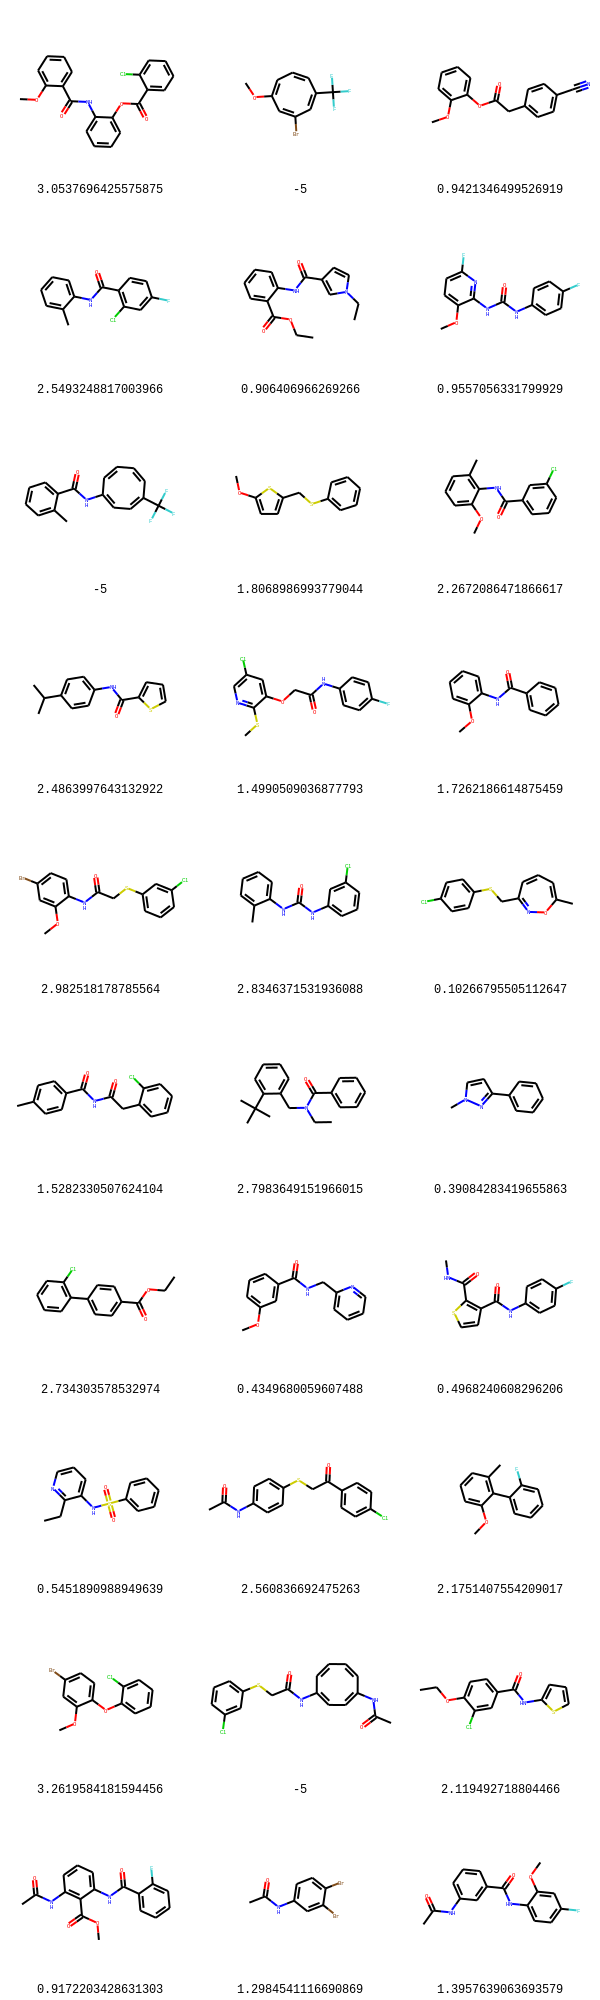

In [ ]:
# Showing some new drug structures that came up
# Final result
from rdkit.Chem import Draw
Draw.MolsToGridImage([get_mol(s) for s in sampled_valid], legends=[str(penalized_logP(s)) for s in sampled_valid])

Final Conclusion: Final Chemical Structures obtained are shown in the above image.